## Introduction

Motivated by the observation of seasonal trends for the S&P500, we now consider if we can make money by trading individual stocks in the S&P500 using seasonality. Specifically, we try to monetize the hypothesis that if in the past a particular stock tends to move up/down over a particular date range, it is likely to continue to move in that direction in the future.

This is a data-mining exercise, and (spoiler alert) we will find that a naive seasonal strategy of picking stocks from the S&P500 will not perform very well. Not surprisingly, the actual performance of the strategy is much worse than what would be predicted simply from averaging past seasonal performance. However, this motivates a follow-on question addressed in a following notebook: what if we refined the seasonal strategy by layering a machine learning algorithm on top of our trading signals?

For now, let us consider the results of directly trading stocks in the S&P500 based off of their seasonal trends. The methodology is as follows: for a given start and end date, identify a stock's price movements in the past 10 years between those dates, and use this to compute an average return and Sharpe ratio across the 10 years' movements. Do this for all S&P500 stocks with stock data going back to 2013 (461 stocks total), for hold durations of 7, 14, or 28 days, and pick the top 5 long/short positions by Sharpe ratio. Repeat this throughout the year.

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np
from itertools import product
import seaborn as sns


# Pre-process data with forward filled fields, in this case using the SP500
# Read in the SP500 tickers from S&P500-Symbols.csv, which was pulled from
# Wikipedia and saved locally.

# Run the below code to pull symbols
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context
# table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
# df = table[0]
# df.to_csv("files/S&P500-Symbols.csv", columns=['Symbol'], index=False)

# Pull the adjusted close prices off Yahoo Finance
df = pd.read_csv("files/S&P500-Symbols.csv")
tickers = list(df['Symbol'])
start_date = '1989-01-01'
end_date = '2024-01-03'  # Get data a few days past end of year to backfill

# Either pull from Yahoo finance, or for read the pre-downloaded CSV
# data = pd.DataFrame(yf.download(tickers, start_date, end_date)['Adj Close'])
# data.reset_index().to_csv("files/S&P500-adjusted-close.csv", index=False)
data = pd.read_csv('files/S&P500-adjusted-close.csv')
data['Date']= pd.to_datetime(data['Date'])
data = data.set_index('Date')
all_dates = pd.date_range(start_date, end_date)
data['Price Date'] = data.index

# Backfill with trading prices for missing dates
data = data.reindex(all_dates, method='bfill')
sp500_dates_added = pd.read_csv("files/S&P500-Info.csv")[['Symbol','Date added']]

all_stocks = data.columns.drop(labels='Price Date')

# Only keep through end of 2023
data = data[data.index < '2024-01-01']

## Define seasonal return and performance metric functions

In [2]:
# Define a function that outputs historical performance between two dates
# Note that this specific function does not work for start and end dates that
# cross a year, e.g. a Dec-Jan seasonal trend

def seasonal_return(data, symbol, start_date, end_date, first_year, last_year):
    data_list = []
    # Deal with Feb 29: assign start/end dates to Mar 1
    if start_date == '02-29': start_date = '03-01'
    if end_date == '02-29': end_date = '03-01'
    for year in range(first_year, (last_year+1)):
        full_start_date = str(year)+'-'+start_date
        full_end_date = str(year)+'-'+end_date
        trade_start_date = data.loc[full_start_date,'Price Date']
        trade_end_date = data.loc[full_end_date,'Price Date']
        start_price = data.loc[full_start_date,symbol]

        # If price data is missing, skip that year
        if np.isnan(start_price):
            continue
        end_price = data.loc[full_end_date,symbol]
        if np.isnan(end_price):
            continue
        returns = (end_price/start_price)-1
        data_list.append([symbol, year, trade_start_date, start_price, 
            trade_end_date,
            end_price, returns])

    df = pd.DataFrame(data_list, columns=['Symbol','Year','Init Date',
        'Init Price','Final Date','Final Price','Return'])
    return df

# An example of finding the best trade given a certain start/end date.
# In this case, Feb 11-16, using data from 2014-2023 (last 10 years)

stock_returns_list = []
start_calendar = '02-11'
end_calendar = '02-16'
start_year = 2014
end_year = 2023
for stock in all_stocks:
    stock_returns_list.append(seasonal_return(data, stock, start_calendar, 
    end_calendar, start_year, end_year))

seasonal_returns = pd.concat(stock_returns_list)

def sortino(df, strat_name, risk_free, threshold):
    excess_return = df[strat_name]-df[risk_free]
    downside = excess_return[(excess_return<df[threshold])]
    denom = np.sqrt(sum(downside*downside)/len(downside))
    return excess_return.mean()/denom

# Generate return stats
def return_stats(x, risk_free_rate = 0):
    d = {}
    d['N'] = x['Symbol'].count()
    d['avg r'] = x['Return'].mean()
    d['vol'] = x['Return'].std()
    downsides = x[x['Return'] < risk_free_rate]['Return']
    d['downside dev'] = 0 if downsides.count()==0 else downsides.std()
    upsides = x[-x['Return'] < risk_free_rate]['Return']
    d['upside dev'] = 0 if upsides.count()==0 else upsides.std()
    d['up'] = sum(x['Return']>risk_free_rate)
    return pd.Series(d, index = ['N','avg r','vol','downside dev','upside dev',
        'up'])

# N is number of observations, avg r is average return for going LONG,
# vol is std dev of returns, downside/upside dev are corresponding deviations
# used to calculate Sortino Ratio, and up is number of observations that are
# above the risk free rate
symbol_stats = seasonal_returns.groupby('Symbol').apply(return_stats, risk_free_rate = 0)

symbol_stats['Sharpe Long'] = symbol_stats['avg r']/symbol_stats['vol']
symbol_stats['Sharpe Short'] = -symbol_stats['avg r']/symbol_stats['vol']
symbol_stats['Sortino Long'] = symbol_stats['avg r']/symbol_stats['downside dev']
symbol_stats['Sortino Short'] = -symbol_stats['avg r']/symbol_stats['upside dev']
symbol_stats['Winrate Long'] = symbol_stats['up']/symbol_stats['N']


# Identify the five most profitable seasonal trades for long/short within the
# window. Restrict to samples that we actually have 10 years of data for
sub_stats = symbol_stats[symbol_stats.N==10]
best_long_trades = sub_stats.sort_values(by='avg r',ascending= False).iloc[0:5]
best_short_trades = sub_stats.sort_values(by='avg r',ascending= True).iloc[0:5]

## Identify seasonal strategies throughout the year

Now that we have a way to identify the top seasonal trades by Sharpe ratio for any given date and hold duration, we apply this function to a series of dates throughout the year. In this case, we consider trades on the dates of 1, 6, 11, 15, 20, and 25 of each month, for durations of 7, 14, and 28 days, for long/short. We use data from 2013-2022 to generate the seasonal pattern, to propose trades in 2023. We constrain to stocks for which we have 10 years of data (i.e. they were in the S&P500 throughout 2013-2023, and have a winrate of at least 6/10 (6/10 gains for long seasonal strategies, 6/10 losses for short seasonal strategies) and annualized return of at least 40%.

**DO NOT RUN THE BELOW CELL DIRECTLY**

In [ ]:
# NOTE: Running this cell will take ~20 minutes. Use the saved CSV file in the next cell instead

# First, restrict to stocks that actually have prices back in 2013 (not NA on
# Jan 1, 2013, even when backfilling). This drops to 461 stocks
sub_cols = data.columns[data.loc['2013-01-01'].notna()]
sub_stocks = data[sub_cols].columns.drop(labels='Price Date')

sub_data = data[sub_cols][data.index>='2013-01-01']

hold_range = [7, 14, 28] # hold for a fixed number of weeks, up to a month
delay_range = [0, 5, 10]
start_months = list(range(1,12+1))
start_days = ['-01','-15']
initial_dates = [str(i)+j for i, j in product(start_months,start_days)]
start_year = 2013
end_year = 2022

all_returns_list = []

# Look up to two weeks forward
for initial_date in initial_dates:

    initial_calendar_2023 = datetime.strptime("2023-"+initial_date, "%Y-%m-%d")

    # Delay refers to how many days after the 1st or 15th we start the trade
    # This technically means we will never start a position on the 29-31st
    for delay in delay_range:
        start_calendar_2023 = initial_calendar_2023+timedelta(days=delay)
        start_calendar = start_calendar_2023.strftime('%m-%d')

        for hold_length in hold_range:
            end_calendar = (start_calendar_2023+timedelta(days=hold_length)
                ).strftime('%m-%d')
            stock_returns_list = []

            for stock in sub_stocks:
                stock_returns_list.append(seasonal_return(sub_data, stock,
                    start_calendar, end_calendar, start_year, end_year))

            seasonal_returns = pd.concat(stock_returns_list)
            symbol_stats = seasonal_returns.groupby('Symbol').apply(
                return_stats, risk_free_rate = 0)
            symbol_stats['trade window']=initial_date
            symbol_stats['start date'] = start_calendar_2023
            symbol_stats['end date'] = end_calendar
            symbol_stats['Sharpe Long'] = symbol_stats['avg r']/symbol_stats['vol']
            symbol_stats['Sharpe Short'] = -symbol_stats['avg r']/symbol_stats['vol']
            symbol_stats['Sortino Long'] = symbol_stats['avg r']/symbol_stats['downside dev']
            symbol_stats['Sortino Short'] = -symbol_stats['avg r']/symbol_stats['upside dev']

            symbol_stats['hold length'] = hold_length
            all_returns_list.append(symbol_stats)

all_returns = pd.concat(all_returns_list)

# Approximately annualize returns
all_returns['annualized r'] = (all_returns['avg r'] * 365/
    all_returns['hold length'])
# all_returns.to_csv('files/seasonal_trades.csv')

In [3]:
all_returns = pd.read_csv('files/seasonal_trades.csv')
# Identify which long/short positions we would take. Take the top 5 long/short for each trade window
long_positions = all_returns[(all_returns['annualized r']>0.4) & (all_returns.up>=6)].sort_values(
    'Sharpe Long',ascending=False).groupby('trade window').head(5)
short_positions = all_returns[(all_returns['annualized r']< (-0.4)) & (all_returns.up<=4)].sort_values(
    'Sharpe Short',ascending=False).groupby('trade window').head(5)

# See the trades we would take, 5 per twice-a-month trading window:
long_positions
# short_positions

,Symbol,N,avg r,vol,downside dev,upside dev,up,trade window,start date,end date,Sharpe Long,Sharpe Short,Sortino Long,Sortino Short,hold length,annualized r
49250,AMZN,10.0,0.078542,0.017979,0.000000,0.017979,10.0,6-15,2023-06-25,07-23,4.368652,-4.368652,inf,-4.368652,28,1.023857
49645,V,10.0,0.052443,0.015724,0.000000,0.015724,10.0,6-15,2023-06-25,07-23,3.335269,-3.335269,inf,-3.335269,28,0.683632
50565,V,10.0,0.039175,0.013205,0.000000,0.013205,10.0,7-01,2023-07-01,07-15,2.966678,-2.966678,inf,-2.966678,14,1.021361
48110,MCO,10.0,0.049429,0.017062,0.000000,0.017062,10.0,6-15,2023-06-20,07-18,2.897025,-2.897025,inf,-2.897025,28,0.644341
81035,CBOE,10.0,0.054347,0.019682,0.000000,0.019682,10.0,10-15,2023-10-20,11-17,2.761226,-2.761226,inf,-2.761226,28,0.708446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14351,CME,10.0,0.033293,0.033520,0.002435,0.028182,8.0,2-15,2023-02-20,03-06,0.993238,-0.993238,13.672623,-1.181376,14,0.868007
74343,MO,10.0,0.051768,0.052473,NaN,0.049556,9.0,9-15,2023-09-25,10-23,0.986575,-0.986575,NaN,-1.044646,28,0.674839
73809,HSY,10.0,0.018696,0.019317,0.003339,0.017434,8.0,9-15,2023-09-25,10-09,0.967866,-0.967866,5.599485,-1.072353,14,0.487429
12749,PEG,10.0,0.024125,0.025988,NaN,0.023429,9.0,2-15,2023-02-15,02-22,0.928323,-0.928323,NaN,-1.029715,7,1.257965


## Seasonal Trade Results

Now let's evaluate the results of making these seasonal trades in 2023.

In [5]:
# Note that within the same trade window, we may end up trading the same stock
# multiple times due to the delay, e.g. we short COF from Jan 11-25 but also
# from Jan 6 to Feb 23. This can happen if a stock endures sustained movements
# in one direction, and we would probably avoid doubling down on the same stock.
# But for now, let's just look at the results of our trades in 2023

long_trades = long_positions.loc[:,['Symbol','start date','end date']]
long_trades['buy date']=long_trades['start date']
long_trades['sell date']="2023-"+long_trades['end date']

# Results of long trades (invert order of buy/sell dates if shorting)
def long_trade_result(data, symbol, buy_date, sell_date):
    [buy_price, actual_buy_date] = data.loc[buy_date][[symbol,'Price Date']]
    [sell_price, actual_sell_date] = data.loc[sell_date][[symbol,'Price Date']]
    trade_return =  (sell_price/buy_price)-1
    return pd.Series({'Symbol':symbol,'Buy Signal Date':buy_date,
        'Actual Buy Date':actual_buy_date,'Buy Price':buy_price,
        'Sell Signal Date':sell_date,'Actual Sell Date':actual_sell_date,
        'Actual Sell Price':sell_price,'Return':trade_return},
        index = ['Symbol','Buy Signal Date','Actual Buy Date','Buy Price',
        'Sell Signal Date','Actual Sell Date','Actual Sell Price','Return'])

long_trade_results_list = []

for row in range(long_trades.shape[0]):
    long_trade_results_list.append(
        long_trade_result(data, long_trades.iloc[row].Symbol,
            long_trades.iloc[row]['buy date'],
            long_trades.iloc[row]['sell date']))

long_trade_results = pd.DataFrame(long_trade_results_list)

short_trades = short_positions.loc[:,['Symbol','start date','end date']]
short_trades['buy date']="2023-"+short_trades['end date']
short_trades['sell date']=short_trades['start date']

short_trade_results_list = []

for row in range(short_trades.shape[0]):
    short_trade_results_list.append(
        long_trade_result(data, short_trades.iloc[row].Symbol,
            short_trades.iloc[row]['buy date'],
            short_trades.iloc[row]['sell date']))

short_trade_results = pd.DataFrame(short_trade_results_list)

Average long return: 0.0314
Sharpe ratio (long): 0.520
Sortino ratio (long): 1.348
Average short return: 0.0133
Sharpe ratio (short): 0.172
Sortino ratio (short): 0.251
Historical long return: 0.0402
Historical 1%ile long Sharpe ratio: 0.936
Historical 1%ile long Sortino ratio: 2.472
Historical short return: 0.0476
Historical 1%ile short Sharpe ratio: 0.498
Historical 1%ile short Sortino ratio: 0.855


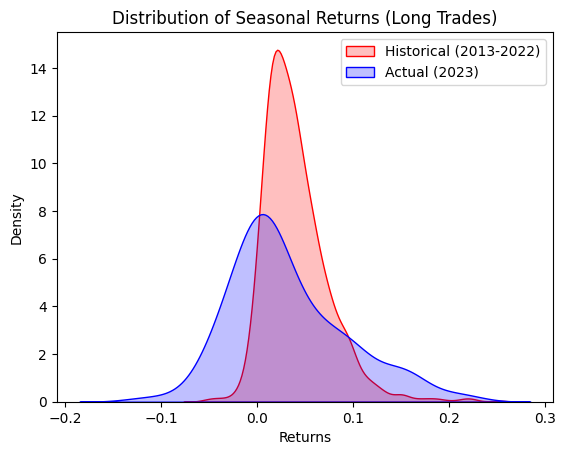

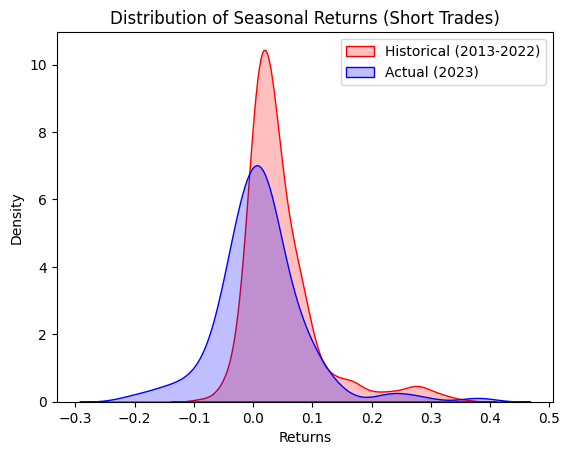

In [6]:
# Long position results
print("Average long return: %5.4f" % long_trade_results['Return'].mean())
print("Sharpe ratio (long): %5.3f" % 
      (long_trade_results['Return'].mean()/long_trade_results['Return'].std()))
print("Sortino ratio (long): %5.3f" % 
      (long_trade_results['Return'].mean()/
       long_trade_results[long_trade_results['Return']<0]['Return'].std()))
# Short position results
print("Average short return: %5.4f" % short_trade_results['Return'].mean())
print("Sharpe ratio (short): %5.3f" % 
      (short_trade_results['Return'].mean()/short_trade_results['Return'].std()))
print("Sortino ratio (short): %5.3f" %
     (short_trade_results['Return'].mean()/
      short_trade_results[long_trade_results['Return']<0]['Return'].std()))

# Compare to what we may have expected if 2023 played out according to historicals:
print('Historical long return: %5.4f' % long_positions['avg r'].mean())
print('Historical 1%%ile long Sharpe ratio: %5.3f' % long_positions['Sharpe Long'].quantile(q=0.01))
print('Historical 1%%ile long Sortino ratio: %5.3f'% long_positions['Sortino Long'].quantile(q=0.01))

print('Historical short return: %5.4f' % -short_positions['avg r'].mean())
print('Historical 1%%ile short Sharpe ratio: %5.3f' %
      short_positions['Sharpe Short'].quantile(q=0.01))
print('Historical 1%%ile short Sortino ratio: %5.3f' %
      short_positions['Sortino Short'].quantile(q=0.01))

# All historical returns for seasonal trades
long_returns_historical_list = []
for row in range(long_positions.shape[0]):
    long_returns_historical_list.append(
        seasonal_return(data,long_positions.iloc[row]['Symbol'],
                        long_positions.iloc[row]['start date'][5:10],
                        long_positions.iloc[row]['end date'], 2013, 2022)['Return'])
long_returns_historical = pd.concat(long_returns_historical_list)


short_returns_historical_list = []
for row in range(short_positions.shape[0]):
    short_returns_historical_list.append(
        seasonal_return(data,short_positions.iloc[row]['Symbol'],
                        short_positions.iloc[row]['start date'][5:10],
                        short_positions.iloc[row]['end date'], 2013, 2022)['Return'])
short_returns_historical = pd.concat(short_returns_historical_list)

# Plot 2023 actual vs 2013-2022 historical
fig = sns.kdeplot(long_returns_historical, fill=True, color="r",label='Historical (2013-2022)')
fig = sns.kdeplot(long_trade_results['Return'], fill=True, color="b",label='Actual (2023)')
fig.legend(loc='upper right')
plt.title("Distribution of Seasonal Returns (Long Trades)")
plt.xlabel('Returns')
plt.show()

# Note that historical returns are negative
fig = sns.kdeplot(-short_returns_historical, fill=True, color="r",label='Historical (2013-2022)')
fig = sns.kdeplot(short_trade_results['Return'], fill=True, color="b",label='Actual (2023)')
fig.legend(loc='upper right')
plt.title("Distribution of Seasonal Returns (Short Trades)")
plt.xlabel('Returns')
plt.show()

## Discussion

It is clear that the actual returns of the seasonal strategy in 2023 underperformed what was expected based off of 2013-2022 performance. Average returns are lower, and the Sharpe and Sortino ratios fall below even the 1 percentile of historical values, among the stocks picked. Much of this is likely due to the data-mining/multiple hypothesis-testing aspects of the strategy: even if the "null" of no advantageous seasonal trades (on average) was true, by picking among hundreds of stocks, it is possible that simply due to chance we would identify seasonally profitable trades. As a final point of reference, how would this strategy have performed vs. simply taking and holding the S&P500 in 2023?

To more directly compare results: consider the returns of a strategy where instead of buying/selling a particular stock and holding for a fixed duration, we just buy the S&P500 (since we know that 2023 was a good year for the S&P500).

In [7]:
# Now what would have happened if we had just bought and held the S&P500 during
# the same period? Since we know that in retrospect, 2023 was a great year for
# the S&P500, let's compute the returns/Sharpe ratio if we had taken long S&P500
# trades (regardless of long/short of the stock) at the same times,
# but over the last 10 years (2014-2023)

# Import S&P500 index (SPX) data
spx = pd.DataFrame(yf.download('^SPX', '2023-01-01', '2024-01-03')['Adj Close'])
all_dates = pd.date_range('2023-01-01', '2024-01-03')
spx['Price Date'] = spx.index
spx = spx.reindex(all_dates, method='bfill')
spx = spx[spx.index < '2024-01-01']

[*********************100%%**********************]  1 of 1 completed


S&P500 long seasonal replication avg return: 0.0132
S&P500 long seasonal replication Sharpe: 0.476
S&P500 long seasonal replication Sortino: 1.101


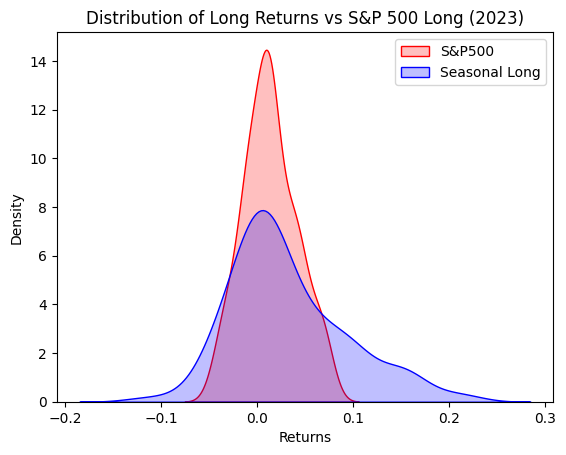

In [8]:
# Long seasonal trades
sp500_returns_long_list = []

# Long trade dates
for idx in range(long_trades.shape[0]):
    buy_date = long_trades.iloc[idx]['buy date']
    sell_date = long_trades.iloc[idx]['sell date']
    buy_price = spx.loc[buy_date]['Adj Close']
    sell_price = spx.loc[sell_date]['Adj Close']
    sp500_return = sell_price/buy_price-1
    sp500_returns_long_list.append([idx,buy_date,sell_date,sp500_return])

sp500_returns = pd.DataFrame(sp500_returns_long_list,
                             columns=['Index','Buy Date','Sell Date','SP500 Return'])

# Avg SP500 returns during the same long positions
# 1.32% avg return
print('S&P500 long seasonal replication avg return: %5.4f' %
      sp500_returns['SP500 Return'].mean())

# Sharpe (assuming risk-free return is just zero): 0.48
print('S&P500 long seasonal replication Sharpe: %5.3f' %
      (sp500_returns['SP500 Return'].mean()/sp500_returns['SP500 Return'].std()))

# Sortino Ratio: 1.10
print('S&P500 long seasonal replication Sortino: %5.3f' %
      (sp500_returns['SP500 Return'].mean()/
       sp500_returns[sp500_returns['SP500 Return']<0]['SP500 Return'].std()))

fig = sns.kdeplot(sp500_returns['SP500 Return'], fill=True, color="r",label='S&P500')
fig = sns.kdeplot(long_trade_results['Return'], fill=True, color="b",label='Seasonal Long')
fig.legend(loc='upper right')
plt.title("Distribution of Long Returns vs S&P 500 Long (2023)")
plt.xlabel('Returns')
plt.show()

S&P500 short seasonal replication Sharpe: 0.0116
S&P500 short seasonal replication Sharpe: 0.185
S&P500 short seasonal replication Sortino: 0.672


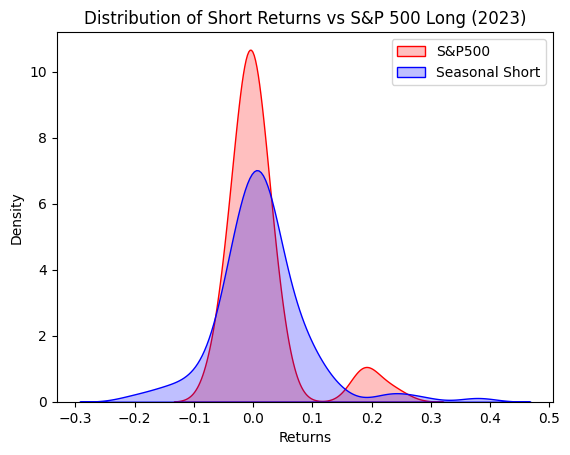

In [9]:
# Short seasonal trades
sp500_returns_short_list = []

# Long trade dates
for idx in range(short_trades.shape[0]):
    buy_date = short_trades.iloc[idx]['buy date']
    sell_date = short_trades.iloc[idx]['sell date']
    buy_price = spx.loc[buy_date]['Adj Close']
    sell_price = spx.loc[sell_date]['Adj Close']
    sp500_return = sell_price/buy_price-1
    sp500_returns_short_list.append([idx,buy_date,sell_date,sp500_return])

sp500_returns_short_dates = pd.DataFrame(sp500_returns_short_list,
    columns=['Index','Buy Date','Sell Date','SP500 Return'])

# Avg SP500 returns during the short positions
# 1.16% avg return
print('S&P500 short seasonal replication Sharpe: %5.4f' %
      sp500_returns_short_dates['SP500 Return'].mean())

# Sharpe: 0.19
print('S&P500 short seasonal replication Sharpe: %5.3f' %
      (sp500_returns_short_dates['SP500 Return'].mean()/
       sp500_returns_short_dates['SP500 Return'].std()))

# Sortino Ratio: 0.67
print('S&P500 short seasonal replication Sortino: %5.3f' %
      (sp500_returns_short_dates['SP500 Return'].mean()/sp500_returns_short_dates[
          sp500_returns_short_dates['SP500 Return']<0]['SP500 Return'].std()))

fig = sns.kdeplot(sp500_returns_short_dates['SP500 Return'], fill=True, color="r",label='S&P500')
fig = sns.kdeplot(short_trade_results['Return'], fill=True, color="b",label='Seasonal Short')
fig.legend(loc='upper right')
plt.title("Distribution of Short Returns vs S&P 500 Long (2023)")
plt.xlabel('Returns')
plt.show()

## Conclusion

Overall, both long and short seasonal strategies have significantly more variability in their returns compared to the S&P500 as a whole. This is to be expected since the S&P500 is an index and should be less volatile than individual stocks.

Taking short seasonal trades during a bull market (which 2023 was in retrospect, with 24% returns from Jan 3, 2023 to Jan 3, 2024) yields average returns comparable to just going long the S&P500 over those same periods (1.33% vs 1.16%). However, taking long seasonal positions does seem to outperform the S&P500 over those same windows (3.14% avg returns over the holding period compared to 1.32% for the S&P500). But, both long/short seasonal strategies perform significantly worse than what would be expected from the historical 10 years' performance, which is to be expected: we are somewhat guilty of finding patterns in the noise and cherry-picking the best results.

But what if we used other information in the markets to inform our seasonal trades? Perhaps the reason the long seasonal strategies did well in 2023 was because it was a bull year: what if it was more like 2022 when the market suffered losses? One refinement for this seasonal strategy is to look at all of the recommended seasonal trades, and then layer on top a "veto" option for trades based off of other features, such as recent price movements. This is explored in the following notebook.